In [22]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [23]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [24]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus Class"].to_list())

In [25]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [26]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [116]:
# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Bottleneck size
n_bottleneck = 6

def create_model():
    
    # Input layer
    input_layer = keras.Input(shape=(n_inputs, 1))
    
    # --------------------
    # Encoder (Trial 14 params)
    # --------------------
    hidden_layer = keras.layers.Conv1D(
        filters=32,              # 1_filter
        kernel_size=6,           # 1_kernal
        activation="relu",
        padding="same"
    )(input_layer)

    hidden_layer = keras.layers.Conv1D(
        filters=128,             # 2_filter
        kernel_size=4,           # 2_kernal
        activation="relu",
        padding="same"
    )(hidden_layer)
    
    # Bottleneck
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck, name="bottleneck")(bottleneck_lay)

    # --------------------
    # Decoder (mirror)
    # --------------------
    reset_lay = keras.layers.Dense(49 * 128)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 128))(reset_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=128,
        kernel_size=4,
        activation="relu",
        padding="same"
    )(reshape_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=32,
        kernel_size=6,
        activation="relu",
        padding="same"
    )(hidden_layer)

    # Output layer
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Models
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model


# Build models
model, encoder_model = create_model()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mse"
)

# Summary
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 49, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 49, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 6)              │        37,638 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6272)           │        43,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_10             │ (None, 49, 128)        │        65,664 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_11             │ (None, 49, 32)         │        24,608 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 49, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,583 (736.65 KB)

 Trainable params: 188,583 (736.65 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25,
                    callbacks=[es_callback])

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3328 - val_loss: 0.0683
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0537 - val_loss: 0.0376
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0368 - val_loss: 0.0292
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0269 - val_loss: 0.0231
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0200 - val_loss: 0.0220
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0190 - val_loss: 0.0193
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0152 - val_loss: 0.0175
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0155 - val_loss: 0.0159
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0132 - val_loss: 0.0157
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0126 - val_loss: 0.0145
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0119 - val_loss: 0.0135
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

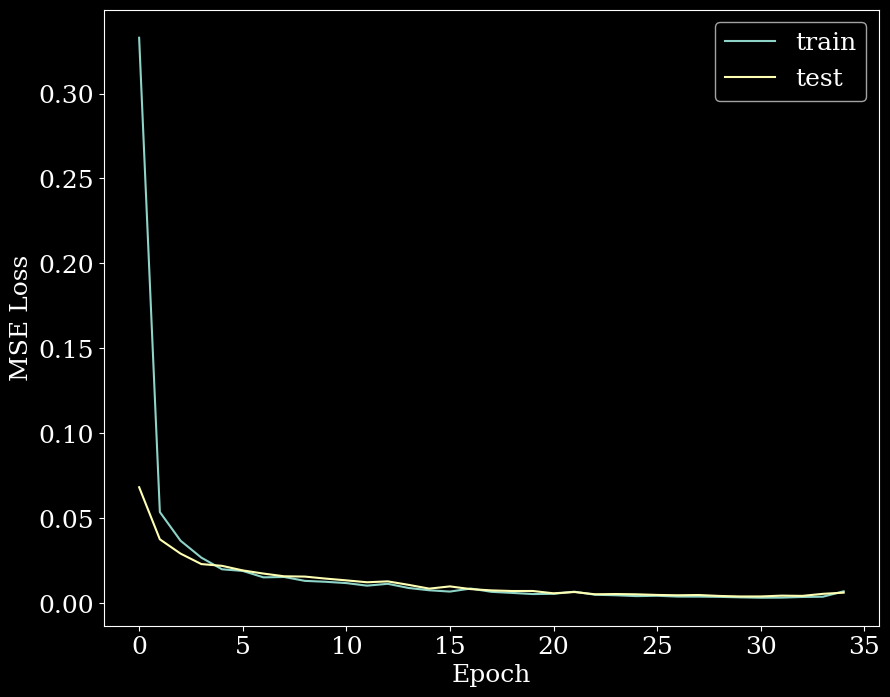

In [118]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


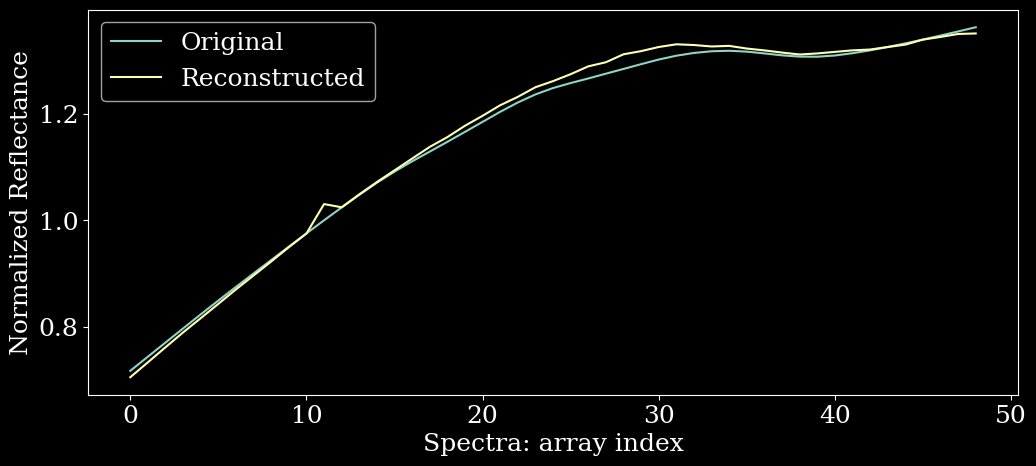

In [119]:
# Which index shall be displayed?
index_val = 100

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [120]:
# Create dataframe that contains the encoder values and the corresponding class to see whether the
# autoencoder values cluster in a way

# Encode the spectra
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the encoded data to fit
# the scaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data (later used for our scikit-learn method)
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [121]:
import hdbscan
import tqdm

# Result dataframe: cluster size, number of clusters, noise ratio, model
hdbscan_results_df = pd.DataFrame(
    [], columns=["Min_Cluster_Size", "Nr_Clusters", "Noise_Ratio", "Model"]
)

min_cluster_sizes = np.arange(5, 51, 5)

for index, mcs in tqdm.tqdm(enumerate(min_cluster_sizes)):

    temp_clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=None,
        metric="euclidean"
    )

    labels = temp_clusterer.fit_predict(X_encoded_scaled)

    nr_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels)

    hdbscan_results_df.loc[index] = [
        mcs,
        nr_clusters,
        noise_ratio,
        temp_clusterer
    ]


10it [00:00, 18.84it/s]


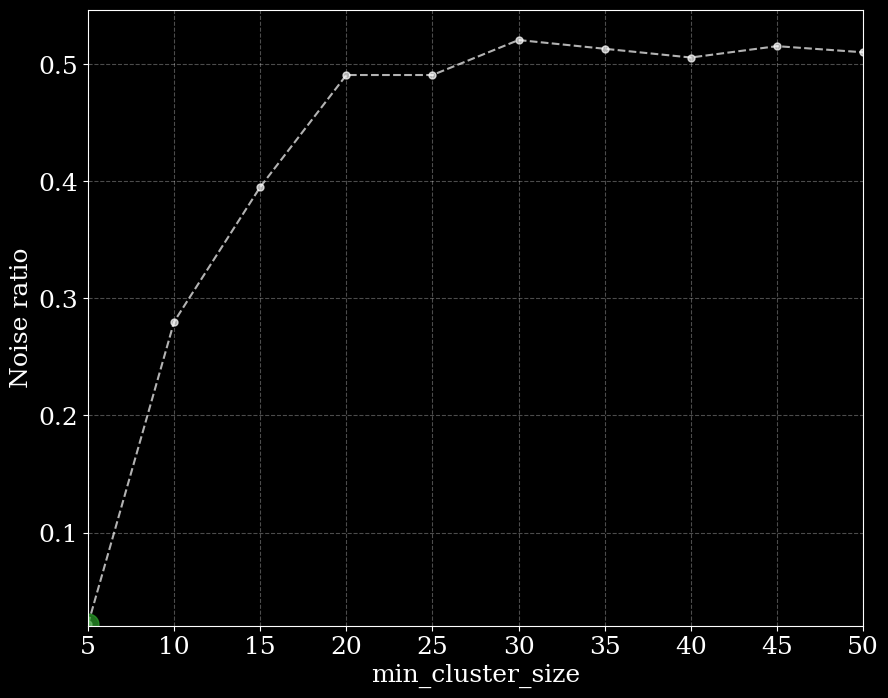

In [122]:
# Matplotlib settings (MATCH GMM)
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

plt.figure(figsize=(10, 8))

# Main curve (white dashed + markers)
plt.plot(
    hdbscan_results_df["Min_Cluster_Size"],
    hdbscan_results_df["Noise_Ratio"],
    linestyle="dashed",
    marker="o",
    markersize=5,
    color="w",
    alpha=0.7
)

# Highlight "best" point (green dot)
best_idx = hdbscan_results_df["Noise_Ratio"].idxmin()

plt.plot(
    hdbscan_results_df.loc[best_idx, "Min_Cluster_Size"],
    hdbscan_results_df.loc[best_idx, "Noise_Ratio"],
    marker="o",
    markersize=15,
    color="tab:green",
    alpha=0.7
)

# Labels
plt.xlabel("min_cluster_size")
plt.ylabel("Noise ratio")

# Grid (same as GMM)
plt.grid(linestyle="dashed", alpha=0.3)

# Axis limits (VERY important for similar look)
plt.xlim(
    hdbscan_results_df["Min_Cluster_Size"].min(),
    hdbscan_results_df["Min_Cluster_Size"].max()
)

plt.ylim(
    hdbscan_results_df["Noise_Ratio"].min() * 0.95,
    hdbscan_results_df["Noise_Ratio"].max() * 1.05
)

plt.show()


In [123]:
best_row = hdbscan_results_df.loc[
    (hdbscan_results_df["Nr_Clusters"] >= 2)
].sort_values("Noise_Ratio").iloc[0]

best_hdbscan = best_row["Model"]


In [124]:
encoded_df.loc[:, "HDBSCAN_Class"] = best_hdbscan.labels_
encoded_df


,enc1,enc2,enc3,enc4,enc5,enc6,Main_Group,Bus_Class,HDBSCAN_Class
0,-0.161196,-1.338337,-2.045229,2.557453,0.042996,1.434227,S,Sr,1
1,1.233424,-1.435879,-0.254592,1.27609,1.499872,0.310323,S,Sl,1
2,0.217273,-0.599854,-0.648623,0.519946,0.448439,0.889616,S,S,1
3,-0.350509,0.743941,-1.16859,-1.155297,-0.081705,1.905451,Other,V,0
4,-1.341584,1.004354,1.197216,-0.628722,-0.924828,-1.299386,C,Ch,1
...,...,...,...,...,...,...,...,...,...
1334,0.338444,-1.896941,-1.728252,2.88282,1.924174,1.543917,S,Sa,1
1335,0.286651,0.225439,0.532141,-0.755258,-0.159775,-0.767213,X,Xc,1
1336,0.645708,0.238763,2.090224,-1.377008,0.903492,-1.351647,X,X,1
1337,-0.65079,0.82849,0.820542,-0.867703,-0.465028,-0.813565,C,C,1


In [125]:
encoded_grouped_df = pd.crosstab(
    index=encoded_df["Main_Group"],
    columns=encoded_df["HDBSCAN_Class"],
    values=encoded_df["enc1"],
    aggfunc="count"
)

encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_clusters = [f"C{k}" for k in encoded_grouped_df.columns.values]


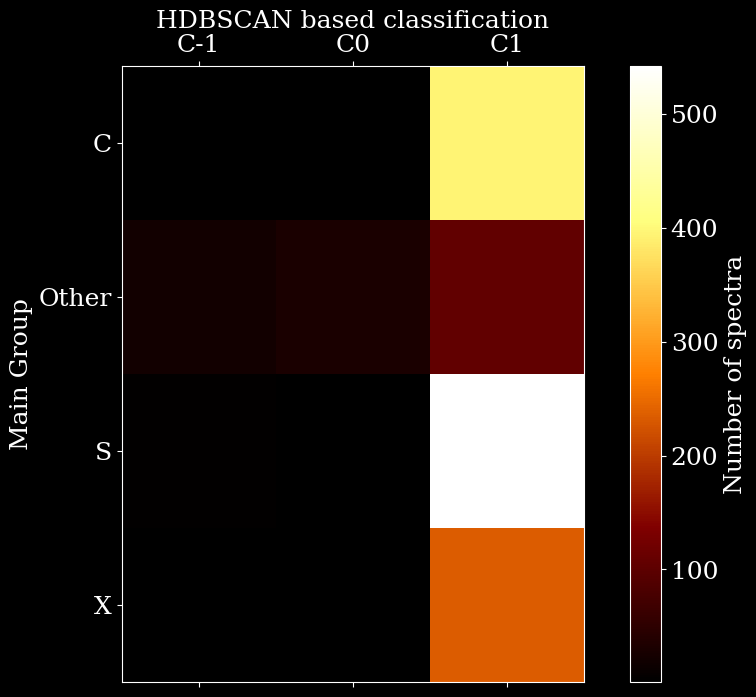

In [126]:
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

ax.set_xticks(range(len(encoded_grouped_clusters)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_clusters)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("HDBSCAN based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top')


In [127]:
encoded_main_s_df = encoded_df.loc[
    encoded_df["Main_Group"] == "S"
].copy()

encoded_main_s_df.groupby("HDBSCAN_Class").count()


,enc1,enc2,enc3,enc4,enc5,enc6,Main_Group,Bus_Class
HDBSCAN_Class,,,,,,,,
-1,4,4,4,4,4,4,4,4
0,3,3,3,3,3,3,3,3
1,542,542,542,542,542,542,542,542


In [128]:
encoded_main_s_df.loc[:, "Cluster_Strength"] = \
    best_hdbscan.probabilities_[encoded_main_s_df.index]

encoded_main_s_df


,enc1,enc2,enc3,enc4,enc5,enc6,Main_Group,Bus_Class,HDBSCAN_Class,Cluster_Strength
0,-0.161196,-1.338337,-2.045229,2.557453,0.042996,1.434227,S,Sr,1,0.617063
1,1.233424,-1.435879,-0.254592,1.27609,1.499872,0.310323,S,Sl,1,1.000000
2,0.217273,-0.599854,-0.648623,0.519946,0.448439,0.889616,S,S,1,1.000000
6,-0.523667,-1.063978,-1.320266,1.47455,1.544652,1.202415,S,S,1,0.986060
7,0.65667,-1.325746,-0.914831,1.131286,1.568915,1.336926,S,Sl,1,1.000000
...,...,...,...,...,...,...,...,...,...,...
1325,0.683575,-0.390788,0.076458,-0.086915,0.395156,0.012993,S,S,1,1.000000
1327,-0.151101,-0.513944,-0.926257,0.728281,0.179749,0.465928,S,S,1,1.000000
1330,0.803038,-0.343073,-0.218623,-0.248227,-0.090937,0.080061,S,S,1,1.000000
1331,0.786972,-0.490157,-1.149376,0.703853,0.532899,0.52539,S,S,1,1.000000


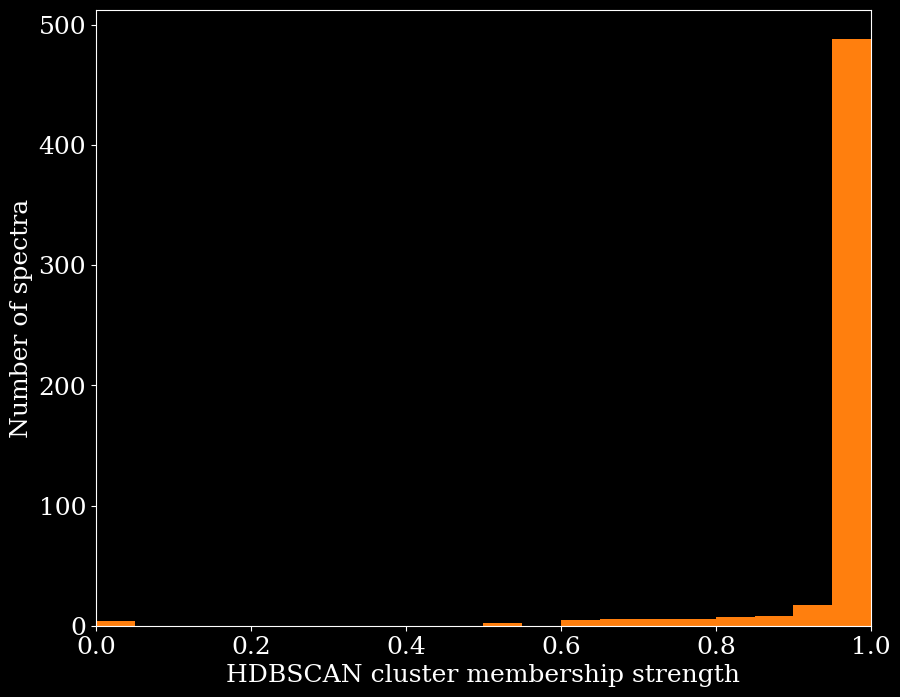

In [129]:
plt.figure(figsize=(10, 8))
plt.hist(encoded_main_s_df["Cluster_Strength"],
         bins=np.arange(0, 1.05, 0.05),
         color="tab:orange")

plt.xlim(0, 1)
plt.xlabel("HDBSCAN cluster membership strength")
plt.ylabel("Number of spectra")
plt.show()


In [130]:
encoded_main_s_df = encoded_main_s_df.loc[
    encoded_main_s_df["Cluster_Strength"] >= 0.95
]


In [131]:
import pingouin

encoded_main_s = np.array(
    encoded_main_s_df[encoder_space_cols].values,
    dtype="float64"
)

pingouin.multivariate_normality(encoded_main_s)


HZResults(hz=np.float64(1.395296185095511), pval=np.float64(2.3231944033641086e-22), normal=False)